# Images stitching & Clustering

#### Author: Maxence Gélard
maxence.gelard@student-cs.fr

This first notebook corresponds to the source code that perform both the image stiching and clustering tasks.
It is divided as follows:

1. Utils: definition of data loading and descriptors computations.
2. Image Snitching - Panorama reconstruction: main code to perform image stiching
3. Image Clustering: definition of two classes `SimpleDetectorClustering`(for KMeans clustering) and `SimilarityDetectorClusterer`for Affinity Propagation clustering
4. Snitch more than 2 images: iteration of the snitching alogorithm to extend it to more than pairs of images
5. Snitch multiple images using clustering results: use the clustering labels and perform snitching on the clusters

In [1]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import normalized_mutual_info_score
import itertools
from collections import defaultdict

# 1. Utils

In [2]:
def load_images():
    labels = []
    images = []
    images_gray = []
    for image_id in os.listdir("images"):
        if not image_id[0] == ".":
            for image in os.listdir(os.path.join("images", image_id)):
                if not image[0] == ".":
                    img = cv2.imread(os.path.join("images", image_id, image))
                    images.append(img)
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images_gray.append(img_gray)
                    labels.append(int(image_id))
    return images, images_gray, labels


def compute_keypoints_descriptors(detector, images):
    keypoints = []
    descriptors = []
    for image in images:
        image_keypoints, image_descriptors = detector.detectAndCompute(image, None)
        keypoints.append(image_keypoints)
        descriptors.append(image_descriptors)
    return keypoints, descriptors

# 2. Image Snitching - Panorama reconstruction

Below is given the main class to perform panorama reconstruction.

`pair_match`: given two images, get the best descriptors matches.

`wrap_image`: given two images and an homography matrix `H`, performs the transformation on one of the image and build the whole panorama.

`compute_homography`: estimation of the homography matrix using RANSAC algorithm.

`align_images_pair`: main function that will call all the subfunctions of this class in order to perform image stitching (on a pair of images).

`crop_after_stiching`: removes black strips from panorama after stiching (post-processing step)


In [3]:
class ImageSnitching:
    def __init__(self, detector, images, images_gray):
        self.detector = detector
        
        self.images = images
        self.images_gray = images_gray
        
        self.keypoints, self.descriptors = compute_keypoints_descriptors(detector, images_gray)
    
    def pair_match(self, i, j, matcher=cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)):
        matches = matcher.match(self.descriptors[i], self.descriptors[j])
        matches = sorted(matches, key = lambda x:x.distance)

        img_match = cv2.drawMatches(
            self.images[i],
            self.keypoints[i],
            self.images[j],
            self.keypoints[j],
            matches[:50],
            self.images[j],
            flags=2
        )
        return matches, img_match
    
    def wrap_image(self, imgage_i, imgage_j, H):
        n_rows_i, n_cols_i = imgage_i.shape[:2]
        n_rows_j, n_cols_j = imgage_j.shape[:2]

        # Define the corners of the images that will be used to perform stiching.
        list_of_points_1 = np.float32([[0,0], [0, n_rows_i],[n_cols_i, n_rows_i], [n_cols_i, 0]]).reshape(-1, 1, 2)
        list_of_points_2 = np.float32([[0, 0], [0, n_rows_j], [n_cols_j, n_rows_j], [n_cols_j,0]]).reshape(-1,1,2)

        # When we have established a homography we need to warp perspective
        # Change field of view.
        list_of_points_2_transformed = cv2.perspectiveTransform(list_of_points_2, H)
        list_of_points = np.vstack([list_of_points_1, list_of_points_2_transformed])

        # Define a translation matrix in order to correct the position of the images.
        [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel())
        [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel())
        H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        
        transformation_matrix = H_translation.dot(H)

        panorama = cv2.warpPerspective(imgage_j, transformation_matrix, (x_max-x_min, y_max-y_min))
        panorama[
            -y_min:n_rows_i-y_min,
            -x_min:n_cols_i-x_min
        ] = imgage_i

        return panorama
    
    def compute_homography(self, i, j):
        matches, img_match = self.pair_match(i, j)
        
        match_points_i = np.float32([self.keypoints[i][m.queryIdx].pt for m in matches])
        match_points_j = np.float32([self.keypoints[j][m.trainIdx].pt for m in matches])

        if np.mean(match_points_i[:, 0]) > np.mean(match_points_j[:, 0]):
        # we look where the keypoints are horizontally
            left = i
            right = j
        else:
            left = j
            right = i
            match_points_i, match_points_j = match_points_j, match_points_i

        H, _ = cv2.findHomography(match_points_i, match_points_j, cv2.RANSAC, 5)
        return left, right, H
    
    def align_images_pair(self, i, j):
        left, right, H = self.compute_homography(i, j)
        wrapped_image = self.wrap_image(self.images[right], self.images[left], H)
        return wrapped_image
    
    @staticmethod
    def crop_after_stiching(snitched_image):
        first_row = 0
        last_row = snitched_image.shape[0] - 1
        while len(np.where(snitched_image[first_row, :] == 0)[0]) > snitched_image.shape[0] / 5:
            first_row += 1

        while len(np.where(snitched_image[last_row, :] == 0)[0]) > snitched_image.shape[0] / 5:
            last_row -= 1
        return snitched_image[first_row:last_row, :]


In [4]:
images, images_gray, labels = load_images()

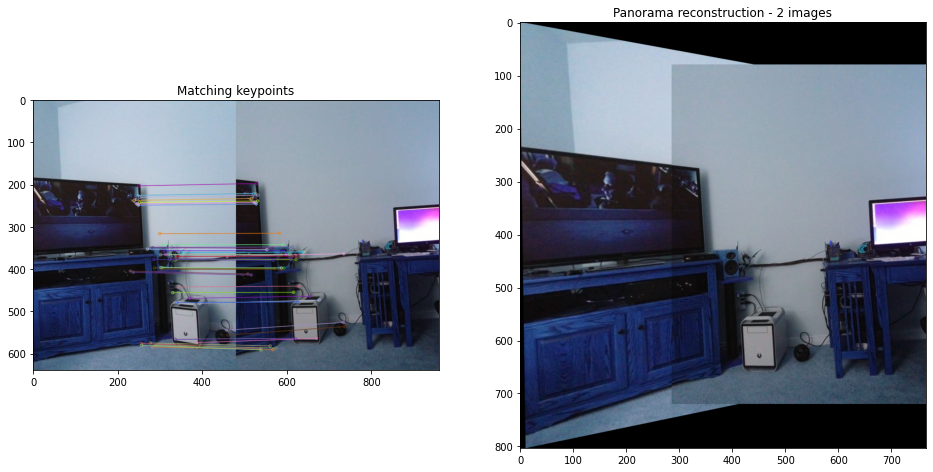

In [5]:
# Example of reconstruction using SIFT detector

detector = cv2.SIFT_create()
image_snitcher = ImageSnitching(detector, images, images_gray)

def plot_pair_alignment(image_snitcher, i, j):
    matches, img_match = image_snitcher.pair_match(i, j)
    snitched = image_snitcher.align_images_pair(i, j)

    fig, ax = plt.subplots(1, 2, figsize=(16, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_match)
    plt.title("Matching keypoints")

    plt.subplot(1, 2, 2)
    plt.imshow(snitched)
    plt.title("Panorama reconstruction - 2 images")
    
plot_pair_alignment(image_snitcher, 0, 1)

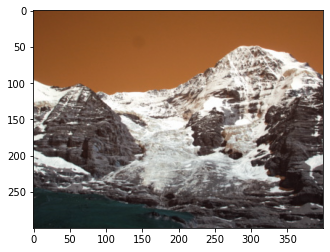

In [6]:
plt.imshow(images[11])

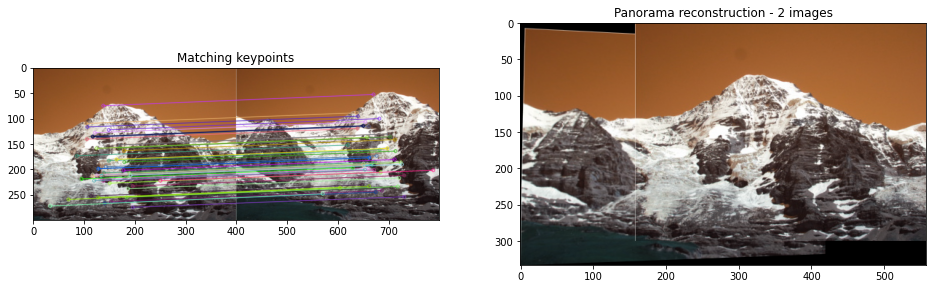

In [7]:
plot_pair_alignment(image_snitcher, 12, 11)

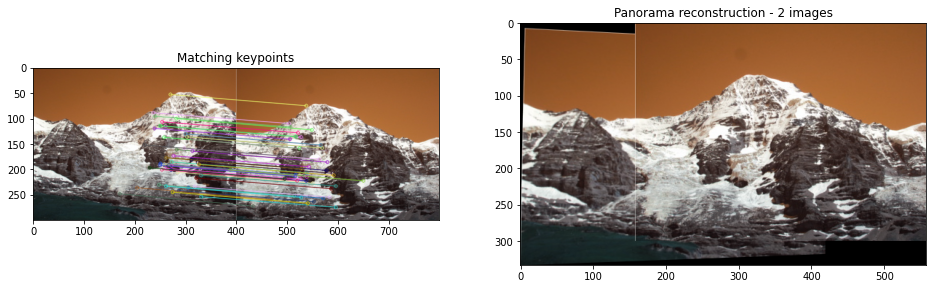

In [8]:
# Proof of the use the heuristic:

plot_pair_alignment(image_snitcher, 11, 12) # we invert the two images, and we'll see that we get the same image

# 3. Image Clustering 

Below are defined two classes that allow to perform image clustering


- `SimpleDetectorClustering`: uses a clustering algorithm (here KMeans) and descriptors to perform image clustering.

- `SimilarityDetectorClusterer`: same as the previous one, but defines a similarity matrix that can be used with Affinity Propagation algorithm.  

In [9]:
class SimpleDetectorClustering:
    def __init__(self, detector, clusterer, images, images_gray, keypoints=None, descriptors=None):
        self.detector = detector
        self.clusterer = clusterer
        
        if keypoints is None:
            self.keypoints, self.descriptors = compute_keypoints_descriptors(detector, images_gray)
        else:
            self.keypoints, self.descriptors = keypoints, descriptors
            
    def get_clusters_labels(self):
        n_descriptors_mapping = [d.shape[0] for d in self.descriptors]
        descriptors_array = np.concatenate([d for d in self.descriptors])
        
        self.clusterer.fit(descriptors_array)
        cluster_labels = self.clusterer.labels_

        final_labels = []
        cumul_index = 0
        for i, n_descriptor in enumerate(n_descriptors_mapping):
            label = np.bincount(cluster_labels[cumul_index:cumul_index+n_descriptor]).argmax()
            final_labels.append(label)
            cumul_index += n_descriptor

        return final_labels
    
# Helper function to snitch images pairs inside each clusters
def generate_cluster_pairs(image_snitcher, descriptors, keypoints, detector_labels, images):
    label_to_pairs = defaultdict(list)
    for label in detector_labels:
        indices = np.where(np.array(detector_labels) == label)[0]
        for (i, j) in itertools.combinations(indices, 2):
            wrapped_image = image_snitcher.align_images_pair(i, j)
            label_to_pairs[label].append(wrapped_image)
    return label_to_pairs


class SimilarityDetectorClusterer:
    def __init__(self, detector, clusterer, images, images_gray, keypoints=None, descriptors=None):
        self.detector = detector
        self.clusterer = clusterer
        
        if keypoints is None:
            self.keypoints, self.descriptors = compute_keypoints_descriptors(detector, images_gray)
        else:
            self.keypoints, self.descriptors = keypoints, descriptors
            
        self.similarity_matrix = None
        self.get_similarity_matrix()
            
    def get_similarity_matrix(self, descriptor_ratio=0.8, n_neighbors=2):
        n_images = len(self.keypoints)
        similarity_matrix = np.zeros((n_images, n_images))
        for i in range(n_images):
            for j in range(n_images):
                descriptors_i = self.descriptors[i]
                descriptors_j = self.descriptors[j]
                
                matcher = cv2.BFMatcher()
                matches = matcher.knnMatch(descriptors_i, descriptors_j, k=n_neighbors)

                for match_i, match_j in matches:
                    if match_i.distance < descriptor_ratio * match_j.distance:
                        similarity_matrix[i, j] += 1.0
            similarity_matrix[i] /= np.sum(similarity_matrix[i])
        self.similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2
        
    def get_clusters_labels(self):
        self.clusterer.fit(self.similarity_matrix)
        cluster_labels = self.clusterer.labels_
        return cluster_labels

In [10]:
# Running Affinity Propagation clustering

detector = cv2.SIFT_create()
clusterer = AffinityPropagation(affinity='precomputed', random_state=None)
similarity_clustering = SimilarityDetectorClusterer(detector, clusterer, images, images_gray)

similarity_clustering_labels = similarity_clustering.get_clusters_labels()

In [11]:
# Running KMeans clustering clustering

n_clusters = len(np.unique(labels))
clusterer = KMeans(n_clusters=n_clusters)
detector = cv2.SIFT_create()

detector_clustering = SimpleDetectorClustering(detector, clusterer, images, images_gray)
detector_labels = detector_clustering.get_clusters_labels()

label_to_pairs = generate_cluster_pairs(
    image_snitcher, 
    detector_clustering.descriptors,
    detector_clustering.keypoints,
    detector_labels,
    images
)

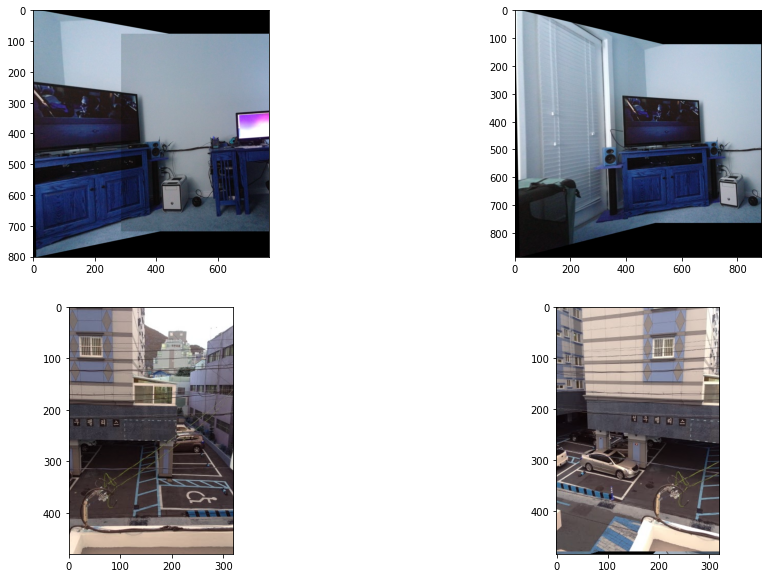

In [12]:
# Plotting pairs of images

label = 0
while len(label_to_pairs[label]) < 4:
    label += 1

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.imshow(label_to_pairs[label][0])

plt.subplot(2, 2, 2)
plt.imshow(label_to_pairs[label][1])

plt.subplot(2, 2, 3)
plt.imshow(label_to_pairs[label][2])

plt.subplot(2, 2, 4)
plt.imshow(label_to_pairs[label][3])

In [13]:
print(f"Clusrering score: {normalized_mutual_info_score(detector_labels, labels)}")
print(f"Affinity score: {normalized_mutual_info_score(similarity_clustering_labels, labels)}")

Clusrering score: 0.6607499141440961
Affinity score: 0.9186973125079317


In [14]:
label_to_pairs_affinity = generate_cluster_pairs(
    image_snitcher,
    similarity_clustering.descriptors,
    similarity_clustering.keypoints,
    similarity_clustering_labels,
    images
)

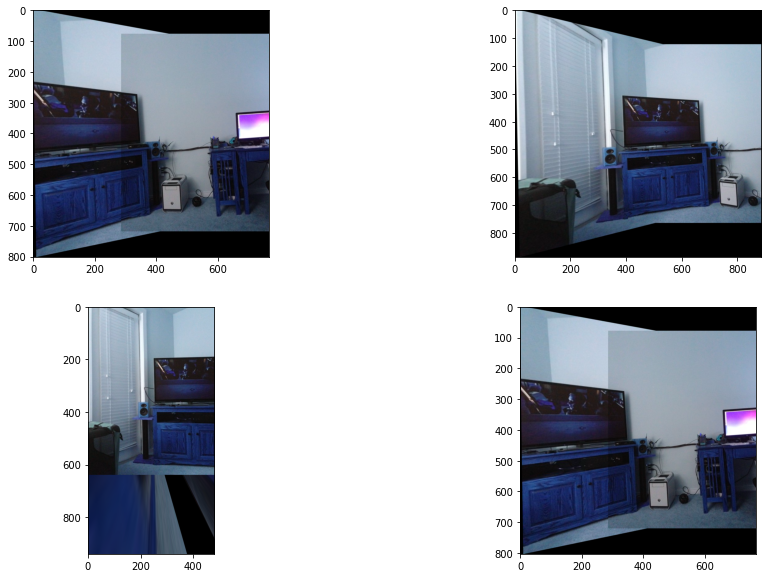

In [15]:
label = 0
while len(label_to_pairs_affinity[label]) < 4:
    label += 1

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.imshow(label_to_pairs_affinity[label][0])

plt.subplot(2, 2, 2)
plt.imshow(label_to_pairs_affinity[label][1])

plt.subplot(2, 2, 3)
plt.imshow(label_to_pairs_affinity[label][2])

plt.subplot(2, 2, 4)
plt.imshow(label_to_pairs_affinity[label][3])

#### Experiments: influence of the number of clusters: (for K-Means)

In [16]:
n_clusters_list = range(2, 9)
nmi_results = {}
for n_clusters in n_clusters_list:
    clusterer = KMeans(n_clusters=n_clusters)
    detector = cv2.SIFT_create()

    detector_clustering = SimpleDetectorClustering(detector, clusterer, images, images_gray)
    detector_labels = detector_clustering.get_clusters_labels()

    nmi = normalized_mutual_info_score(detector_labels, labels)
    nmi_results[n_clusters] = nmi
    
print(nmi_results)

{2: 0.5128569313667494, 3: 0.7082175260708945, 4: 0.6607499141440961, 5: 0.797908552478895, 6: 0.5978156534363815, 7: 0.6467403796538602, 8: 0.5497965011801114}


# 4. Snitch more than 2 images

In this section, we use the same snitching algorithm to perform panorama reconstruction with more than 2 images. The idea is to use a former step of snitching (e.g with only one pair of images) with a new image, and we iterate recursively with the same algorithm until we have processed all images.

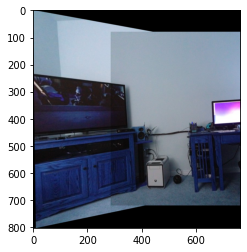

In [17]:
wrapped_image = image_snitcher.align_images_pair(0, 1)
plt.imshow(wrapped_image)

In [18]:
def snitch_multiple_images(image_snitcher: ImageSnitching, images_indices):
    assert len(images_indices) >= 3
    i, j = images_indices[0], images_indices[1]
    n_initial = len(image_snitcher.images)
    wrapped_image = image_snitcher.align_images_pair(i, j)
    for k in images_indices[2:]:
        new_image_index = k
        wrapped_keypoints, wrapped_descriptors = image_snitcher.detector.detectAndCompute(
            cv2.cvtColor(wrapped_image, cv2.COLOR_BGR2GRAY), None
        )
        image_snitcher.keypoints.append(wrapped_keypoints)
        image_snitcher.descriptors.append(wrapped_descriptors)
        image_snitcher.images.append(wrapped_image)
        
        wrapped_image = image_snitcher.align_images_pair(k, len(image_snitcher.images) - 1)
        
    # delete what has been added
    image_snitcher.keypoints = image_snitcher.keypoints[:n_initial]
    image_snitcher.descriptors = image_snitcher.descriptors[:n_initial]
    image_snitcher.images = image_snitcher.images[:n_initial]
    return wrapped_image

Text(0.5, 1.0, 'Panorama - post-processing')

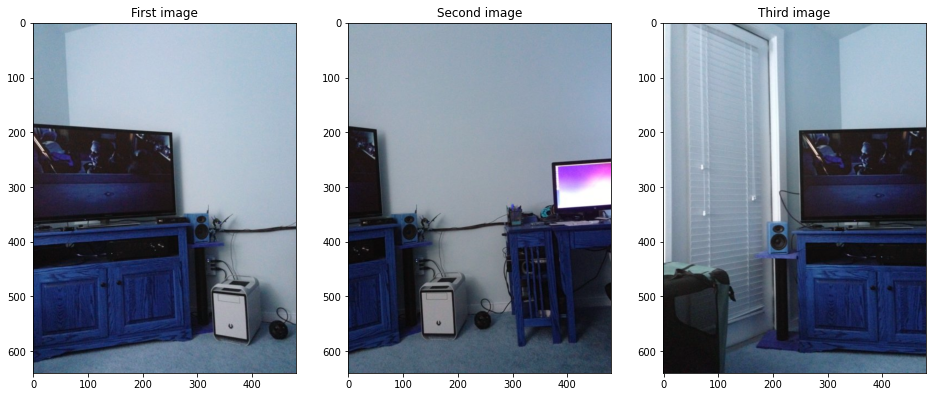

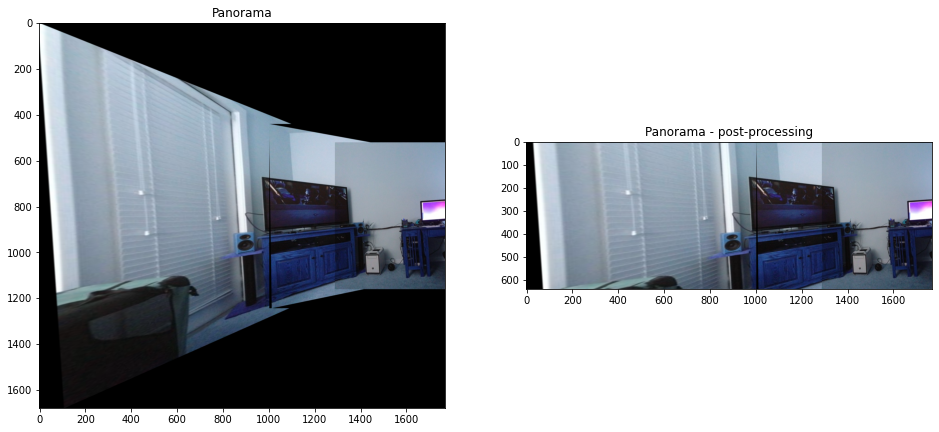

In [19]:
res = snitch_multiple_images(image_snitcher, [0, 1, 2])

fig, ax = plt.subplots(1, 3, figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(images[0])
plt.title("First image")

plt.subplot(1, 3, 2)
plt.imshow(images[1])
plt.title("Second image")

plt.subplot(1, 3, 3)
plt.imshow(images[2])
plt.title("Third image")

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(res)
plt.title("Panorama")

plt.subplot(1, 2, 2)
plt.imshow(image_snitcher.crop_after_stiching(res))
plt.title("Panorama - post-processing")

# 5. Snitch multiple images using clustering results

This section relies on all the previous ones to perform image snitching on images from the same clusters.

Text(0.5, 1.0, 'Panorama - post-processing')

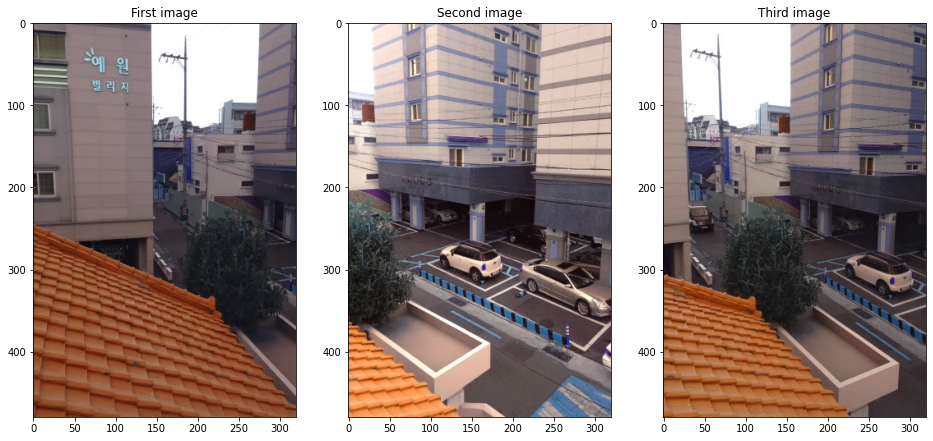

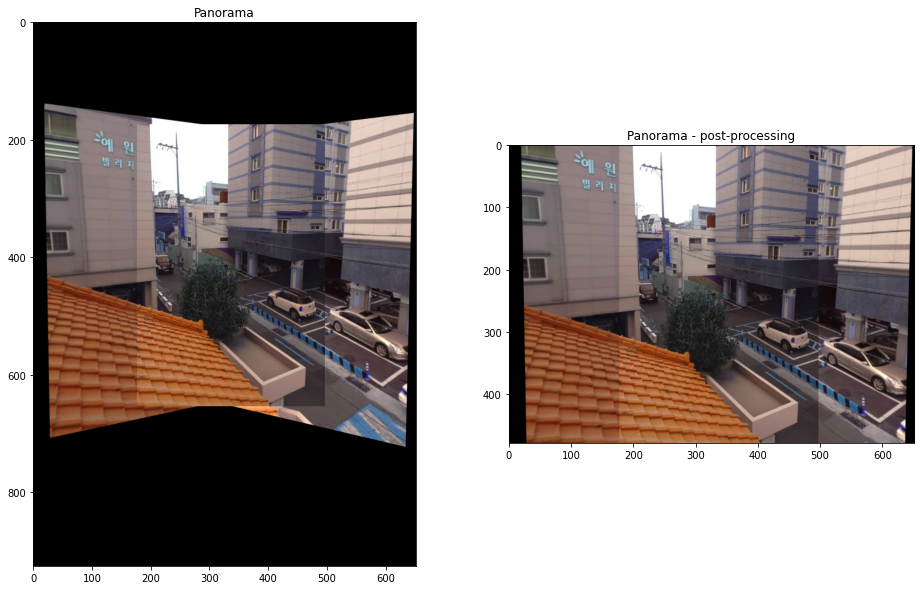

In [20]:
label = 3
images_to_snitch = list(np.where(similarity_clustering_labels == label)[0])

res_with_clustering = snitch_multiple_images(image_snitcher, images_to_snitch)


fig, ax = plt.subplots(1, 3, figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(images[images_to_snitch[0]])
plt.title("First image")

plt.subplot(1, 3, 2)
plt.imshow(images[images_to_snitch[1]])
plt.title("Second image")

plt.subplot(1, 3, 3)
plt.imshow(images[images_to_snitch[2]])
plt.title("Third image")

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(res_with_clustering)
plt.title("Panorama")

plt.subplot(1, 2, 2)
plt.imshow(image_snitcher.crop_after_stiching(res_with_clustering))
plt.title("Panorama - post-processing")

Thanks for reading!

Acknowledgement to some tutorials that helped me, namely managing opencv:
- https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/
- https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
- https://towardsdatascience.com/improving-your-image-matching-results-by-14-with-one-line-of-code-b72ae9ca2b73``
- https://kushalvyas.github.io/stitching.html